Enfoque del dataset de noticias falsas basado en CNN

In [6]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install textaugment
from textaugment import EDA

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Cargar Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/TFM/Data/Huhu/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore')
df = df[['tweet', 'humor']]
df = df.rename(columns={"tweet": "Text", "humor": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55, stratify=y_train)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55, stratify=y_aux)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 1869
Tamaño conjunto de Validación: 272
Tamaño conjunto de Evaluación: 530


# Data Augmentation

t = EDA()

i = 0
for i in range(1869):
    new_text = t.synonym_replacement(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    new_text = t.random_swap(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    new_text = t.random_deletion(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    i = i + 1
    
print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Evaluación:', len(X_test)) 

# Preprocesamiento y Limpieza

In [9]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("spanish")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con 1 carácter
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial 
    min_length = 1
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>= min_length and p.match(token):
            filtered_tokens.append(token)
    
    new_text = ""
    for token in filtered_tokens:
        new_text = new_text + str(token) + " "
    
    return new_text


for text in X_train:
    text = clean_text(text)

# Label Encoding

In [10]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {0: 0, 1: 1}


# Tokenización

In [11]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 8613


In [12]:
# Análisis de Longitud #
# Train_len = X_train.apply(lambda text: len(str(text).split()))
# Train_len.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

In [13]:
MAX_LEN = 55

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# CNN

In [14]:
EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 200)           1722600   
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 32)            4

Training:

In [15]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/20
117/117 [==============================] - 13s 92ms/step - loss: 0.5669 - accuracy: 0.6891 - val_loss: 0.5458 - val_accuracy: 0.7463
Epoch 2/20
117/117 [==============================] - 11s 95ms/step - loss: 0.3416 - accuracy: 0.8550 - val_loss: 0.5451 - val_accuracy: 0.7647
Epoch 3/20
117/117 [==============================] - 12s 102ms/step - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.5947 - val_accuracy: 0.7721
Epoch 4/20
117/117 [==============================] - 13s 112ms/step - loss: 0.0509 - accuracy: 0.9845 - val_loss: 0.7069 - val_accuracy: 0.7610
Epoch 5/20
117/117 [==============================] - 11s 97ms/step - loss: 0.0298 - accuracy: 0.9893 - val_loss: 0.6972 - val_accuracy: 0.7978


Curvas de Aprendizaje:

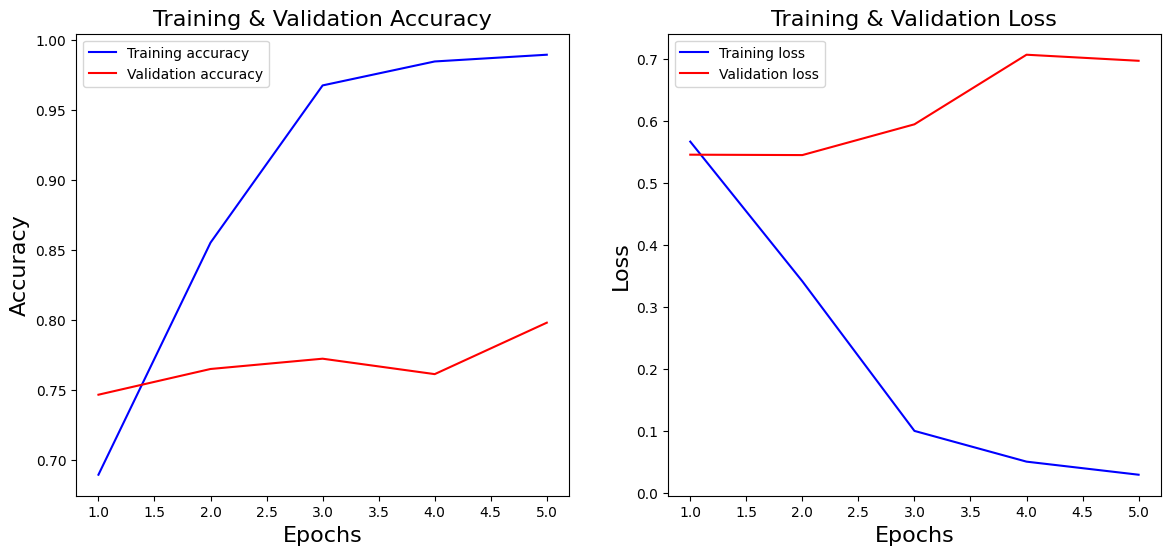

In [16]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

17/17 [==============================] - 0s 10ms/step
Accuracy: 0.7981132075471699
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       358
           1       0.72      0.61      0.66       172

    accuracy                           0.80       530
   macro avg       0.78      0.75      0.76       530
weighted avg       0.79      0.80      0.79       530



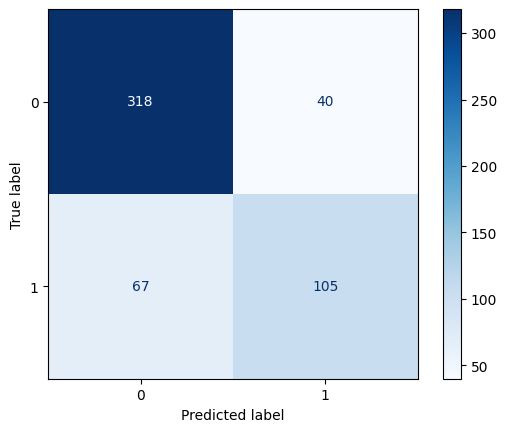

In [17]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0','1']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot(cmap=plt.cm.Blues,values_format='g')